## Prerequisites

Install the required dependencies:

In [ ]:
!pip install git+https://github.com/handley-lab/blackjax
!pip install tqdm anesthetic numpy

# Custom Inner MCMC Kernels

The common top level API presented in other notebooks, `nss` is unfamiliar to those used to the SMC implementations in blackjax. It is a fusion of the generic outer NS kernel with a particular inner kernel, slice sampling.

It is instructive then to examine both how this combination is built, and how one could combine a new choice of inner MCMC kernel with the slice sampling procedure.

In [2]:
import tqdm
import jax
import jax.numpy as jnp
from functools import partial
from blackjax.ns.adaptive import build_kernel, init
from blackjax.ns.base import new_state_and_info, delete_fn
from blackjax.ns.utils import repeat_kernel, finalise
from blackjax.mcmc.random_walk import build_rmh, RWState
from blackjax import SamplingAlgorithm


## Setting up a constrained random walk

To be compatible with nested sampling we have to address two oddities with respect to other algorithms in blackjax:
- We need to implement a constrained random walk, rather than purely accepting based on a metropolis acceptance ratio, there is an additional imposed constraint.
- To perform the post run reconstruction we need to record the value of the constraint (likelihood), rather than just operating on a density

To do this let's construct a random walk kernel in the usual blackjax style, and address these two issues 

(We also include the kernel tuning for a basic random walk here)

In [3]:
mcmc_kernel = build_rmh()

def random_walk_kernel(rng_key, state, logprior_fn, loglikelihood_fn, loglikelihood_0, params):

    def proposal_distribution(rng_key, position):
        """ 
        Proposes a new position by adding Gaussian noise to the current position.
        The noise is scaled by the 'sigma' parameter that our tuning function will set.
        """
        step = params['sigma'] * jax.random.normal(rng_key, shape=position.shape) 
        return position + step

    mcmc_state = RWState(position=state.position, logdensity=state.logprior)
    new_mcmc_state, mcmc_info = mcmc_kernel(rng_key, mcmc_state, logprior_fn, proposal_distribution)

    # As the walk occurs in the prior, we need to separately compute the loglikelihood
    loglikelihood = loglikelihood_fn(new_mcmc_state.position)

    # Now use a ns.utils function to construct a PartitionedState, a wrapper of the above MCMC state to include the likelihood
    new_state, info = new_state_and_info(
        position=new_mcmc_state.position,
        logprior=new_mcmc_state.logdensity,
        loglikelihood=loglikelihood,
        info=mcmc_info,
        )

    # Accept if the loglikelihood is greater than the threshold
    new_state = jax.lax.cond(
        loglikelihood > loglikelihood_0,
        lambda _: new_state,
        lambda _: state,
        operand=None,
    )

    return new_state, info

def update_random_walk_kernel_params(state, info, params):
    """A basic tuning function that updates the std of the particles."""
    sigma = state.particles.std(axis=0)
    return {'sigma': sigma}

## Using the adaptive NS functions

We now need to compose this set inner kernel with the Nested Sampling "outer" kernel

Note: We do not check that an MCMC step has been successful here, so may incur some spurious autocorrelation

In [ ]:
def ns_mcmc(
    logprior_fn,
    loglikelihood_fn,
    num_delete=10,
    num_inner_steps=10,
):
    """
    Build a nested sampling MCMC algorithm. This emulates how the `nss` top level api works,
    
    Parameters
    ----------
    logprior_fn : callable
        Function that computes the log prior probability of the parameters.
    loglikelihood_fn : callable
        Function that computes the log likelihood of the parameters.
    num_delete : int
        Number of particles to delete at each step.
    num_inner_steps : int
        Number of inner MCMC steps to perform.
    
    Returns
    -------
    init_fn : callable
        Function to initialize the nested sampling state.
    step_fn : callable
        Function to perform a single step of nested sampling.
    """
    
    inner_kernel = repeat_kernel(num_repeats=num_inner_steps)(random_walk_kernel)
    _delete_fn = partial(delete_fn, num_delete=num_delete)

    step_fn = build_kernel(
        logprior_fn,
        loglikelihood_fn,
        _delete_fn,
        inner_kernel,
        update_random_walk_kernel_params,
    )

    init_fn = partial(
        init,
        logprior_fn=logprior_fn,
        loglikelihood_fn=loglikelihood_fn,
        update_inner_kernel_params_fn=update_random_walk_kernel_params,
    )

    return SamplingAlgorithm(init_fn, step_fn)


## Problem definition

Define a small fitting problem of a 2D Gaussian

In [21]:

μ = 0.5
σ = 0.1
μ0 = 0.0
σ0 = 1.0
loglikelihood_fn = lambda x: jax.scipy.stats.norm.logpdf(x, loc=μ, scale=σ).sum()
logprior_fn = lambda x: jax.scipy.stats.norm.logpdf(x, loc=μ0, scale=σ0).sum()

rng_key = jax.random.PRNGKey(0)

num_live = 100
num_delete = 50
num_dims = 2
rng_key, prior_key = jax.random.split(rng_key)
particles = jax.random.normal(prior_key, (num_live, num_dims)) * σ0 + μ0



This can be run in a similar way and exported to the plotting tools. Note this inner kernel is not expected to perform well in high dimension or for more complex processes so should be considered more of a pedagogical example

In [22]:
nested_sampler = ns_mcmc(
    logprior_fn=logprior_fn,
    loglikelihood_fn=loglikelihood_fn,
    num_delete=num_delete,
    num_inner_steps=10,
)

init_fn = jax.jit(nested_sampler.init)
step_fn = jax.jit(nested_sampler.step)

live = init_fn(particles)
dead = []
with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not live.logZ_live - live.logZ < -3:
        rng_key, subkey = jax.random.split(rng_key, 2)
        live, dead_info = step_fn(subkey, live)
        dead.append(dead_info)
        pbar.update(num_delete)

dead = finalise(live, dead)


Dead points: 600 dead points [00:00, 830.76 dead points/s]


In [23]:
from anesthetic import NestedSamples
columns = [f"x{i}" for i in range(num_dims)]
labels = [f"$x_{i}$" for i in range(num_dims)]
samples = NestedSamples(
    dead.particles,
    logL=dead.loglikelihood,
    logL_birth=dead.loglikelihood_birth,
    columns=columns,
    labels=labels,
    logzero=jnp.nan,
    dtype=jnp.float64,
)

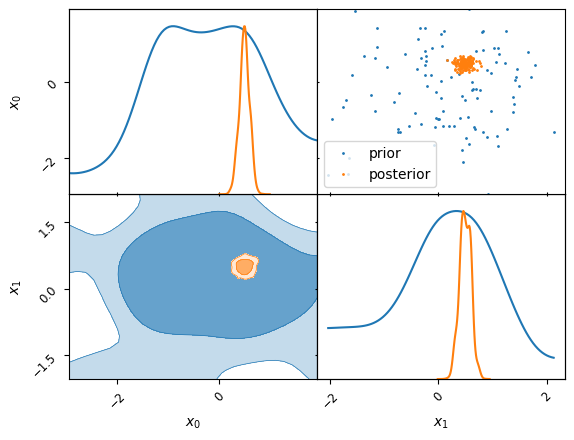

In [28]:
a=samples.set_beta(0.0).plot_2d(columns, label="prior")
samples.set_beta(1.0).plot_2d(a, label="posterior")
a.iloc[0, 1].legend()